In [50]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import os
import shutil
import argparse
import pdb

import sys
sys.path.insert(0, '../')
from utils import metrics, sample_gt, softmax,calprecision
from datasets import get_dataset, get_originate_dataset
from DenseConv import *
import argparse
from skimage.segmentation import felzenszwalb
import time
from scipy.stats import entropy
import matplotlib.pyplot as plt
import time

In [5]:
datasets_root = '/mnt/data/leevi/'
DATASET = 'hyrank'
SAMPLE_PERCENTAGE = 5
img, gt, LABEL_VALUES, IGNORED_LABELS, ALL_LABELS, _, _ = get_dataset(DATASET, datasets_root)
X, Y = get_originate_dataset(DATASET, datasets_root)
train_gt, test_gt = sample_gt(gt, SAMPLE_PERCENTAGE, mode='fixed')


/home/leevi/SSL-for-HSI-classification/notebooks/../utils.py:477: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_gt[train_indices] = gt[train_indices]
/home/leevi/SSL-for-HSI-classification/notebooks/../utils.py:478: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  test_gt[test_indices] = gt[test_indices]


In [2]:
pseudo_labelpath = '../hyrank/pseudo_labels/pseudo_labels3/pseudo_labels3.npy'
pseudo_labels3 = np.load(pseudo_labelpath)

In [136]:
def get_pseudo_label(segments, TRAIN_Y, gt):
    MAX_S = np.max(segments)
    MAX_Y = np.max(TRAIN_Y)
    pseudo_label = np.zeros([np.shape(TRAIN_Y)[0], np.shape(TRAIN_Y)[1], TRAIN_Y.max() + 1])
    idx = TRAIN_Y > 0
    tmp_Y, tmp_s = TRAIN_Y[idx], segments[idx]

    for i_tmp_s, i_tmp_Y in zip(tmp_s, tmp_Y):
        if i_tmp_Y > 0:
            pseudo_label[segments == i_tmp_s, i_tmp_Y] = 1

    pseudo_label[gt == 0, :] = 0
    return pseudo_label


def four_rotation(matrix_0):
    matrix_90 = np.rot90(matrix_0, k=1, axes=(0, 1))
    matrix_180 = np.rot90(matrix_90, k=1, axes=(0, 1))
    matrix_270 = np.rot90(matrix_180, k=1, axes=(0, 1))
    return [matrix_0, matrix_90, matrix_180, matrix_270]


def rotation(matrix_x, matrix_y, pseudo_label=None, segments=None, Mirror=False):
    train_PL, train_SG = [], []
    if pseudo_label is None: train_PL = None
    if segments is None: train_SG = None
    if Mirror == True:
        train_IMG, train_Y = four_rotation(matrix_x[::-1, :, :]), four_rotation(matrix_y[::-1, :])
        if pseudo_label is not None:
            for k_pseudo_label in pseudo_label:
                train_PL.append(four_rotation(k_pseudo_label[::-1, :, :]))
        if segments is not None:
            for k_segments in segments:
                train_SG.append(four_rotation(k_segments[::-1, :, :]))
    else:
        train_IMG, train_Y = four_rotation(matrix_x), four_rotation(matrix_y)
        if pseudo_label is not None:
            for k_pseudo_label in pseudo_label:
                train_PL.append(four_rotation(k_pseudo_label))
        if segments is not None:
            for k_segments in segments:
                train_SG.append(four_rotation(k_segments))

    return train_IMG, train_Y, train_PL, train_SG


def H_segment(img, train_gt, params, gt):
    pseudo_label, idx = [], []
    path = "Datasets/" + params.DATASET + '/' + params.DATASET + '_felzenszwalb.npy'

    if os.path.exists(path) == True:
        all_segment = np.load("Datasets/" + params.DATASET + '/' + params.DATASET + '_felzenszwalb.npy')
    else:
        idd, idy = 1, []
        while idd < np.shape(gt)[0] * np.shape(gt)[1]:
            current_segment = felzenszwalb(img, scale=1.0, sigma=0.95, min_size=idd)
            if len(idy) > 0:
                if np.sum(current_segment - idy[-1]) != 0:
                    print(idd, np.sum(current_segment - idy[-1]), len(idy))
                    idy.append(current_segment)
            else:
                idy.append(current_segment)
            _, counts = np.unique(current_segment, return_counts=True)
            idd = max(counts.min(), idd + 1)

        all_segment = np.stack(idx, 0)
        np.save(path, all_segment)

    for current_segment in all_segment:
        tmp = get_pseudo_label(current_segment, train_gt, gt)
        count_tmp = tmp.sum(-1)
        if np.sum(count_tmp > 0) == np.sum(gt > 0):
            print(len(pseudo_label))
            return pseudo_label

        if len(idx) > 0:
            for k_idx in idx:
                tmp[k_idx > 0, :] = 0

        if tmp.sum() > 0:
            print(len(pseudo_label), count_tmp.max(), np.sum(count_tmp > 0), np.sum(gt > 0))
            idx.append(count_tmp)
            pseudo_label.append(tmp)


def pre_data(img, train_gt, params, gt,pseudo_labels3):
    TRAIN_IMG, TRAIN_Y, TRAIN_PL, TRAIN_SG = [], [], [], []
    #pseudo_labels = H_segment(img, train_gt, params, gt)
    #pseudo_labels2=[pseudo_labels[0]]
    pseudo_labels2 = [pseudo_labels3]
    ##
    # pseudo_labels=None
    ##
    train_IMG, train_Y, train_PL, train_SG = rotation(img, train_gt, pseudo_labels2)
    train_IMG_M, train_Y_M, train_PL_M, train_SG_M = rotation(img, train_gt, pseudo_labels2, Mirror=True)

    image_Column = torch.Tensor(np.stack((train_IMG[0], train_IMG[2], train_IMG_M[0], 
                                          train_IMG_M[2]), 0))#.permute(0, 3,
                                                              #         1, 2)
    y_Column = torch.LongTensor(np.stack((train_Y[0], train_Y[2], train_Y_M[0], train_Y_M[2]), 0).astype(int))

    image_Row = torch.Tensor(np.stack((train_IMG[1], train_IMG[3], train_IMG_M[1], 
                                       train_IMG_M[3]), 0))#.permute(0, 3, 1,2)
    y_Row = torch.LongTensor(np.stack((train_Y[1], train_Y[3], train_Y_M[1], train_Y_M[3]), 0).astype(int))

    if train_PL is not None:
        y_PL_Column, y_PL_Row = [], []
        for k_PL, k_PL_M in zip(train_PL, train_PL_M):
            y_PL_Column.append(torch.FloatTensor(np.stack((k_PL[0], k_PL[2], k_PL_M[0], k_PL_M[2]), 0).astype(float)))
            y_PL_Row.append(torch.FloatTensor(np.stack((k_PL[1], k_PL[3], k_PL_M[1], k_PL_M[3]), 0).astype(float)))
        TRAIN_PL.append(y_PL_Column)
        TRAIN_PL.append(y_PL_Row)
    else:
        TRAIN_PL = None

    if train_SG is not None:
        y_SG_Column, y_SG_Row = [], []
        for k_SG, k_SG_M in zip(train_SG, train_SG_M):
            y_SG_Column.append(torch.FloatTensor(np.stack((k_SG[0], k_SG[2], k_SG_M[0], k_SG_M[2]), 0).astype(float)))
            y_SG_Row.append(torch.FloatTensor(np.stack((k_SG[1], k_SG[3], k_SG_M[1], k_SG_M[3]), 0).astype(float)))
        TRAIN_SG.append(y_SG_Column)
        TRAIN_SG.append(y_SG_Row)
    else:
        TRAIN_SG = None

    TRAIN_IMG.append(image_Column)
    TRAIN_IMG.append(image_Row)
    TRAIN_Y.append(y_Column)
    TRAIN_Y.append(y_Row)

    return TRAIN_IMG, TRAIN_Y, TRAIN_PL, TRAIN_SG


In [139]:
INPUT_DATA = pre_data(img, train_gt, {}, gt,pseudo_labels3)

In [141]:
INPUT_DATA[0][1].shape

torch.Size([4, 710, 16640, 147])

In [14]:
#datasets_root = '/mnt/data/leevi/'
DATASET = 'IndianPines'
#SAMPLE_PERCENTAGE = 5
img_ip, gt_ip, LABEL_VALUES_ip, IGNORED_LABELS_ip, ALL_LABELS_ip, _, _ = get_dataset(DATASET, datasets_root)
X_ip, Y_ip = get_originate_dataset(DATASET, datasets_root)
train_gt_ip, test_gt_ip = sample_gt(gt_ip, SAMPLE_PERCENTAGE, mode='fixed')
pseudo_labelpath = '../PaviaU/pseudo_labels/pseudo_labels3/pseudo_labels3.npy'
pseudo_labels3_ip = np.load(pseudo_labelpath)

/home/leevi/SSL-for-HSI-classification/notebooks/../utils.py:477: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_gt[train_indices] = gt[train_indices]
/home/leevi/SSL-for-HSI-classification/notebooks/../utils.py:478: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  test_gt[test_indices] = gt[test_indices]


In [137]:
INPUT_DATA_ip = pre_data(img_ip, train_gt_ip, {}, gt,pseudo_labels3_ip)

In [138]:
INPUT_DATA_ip[0][0].shape

torch.Size([4, 145, 145, 200])

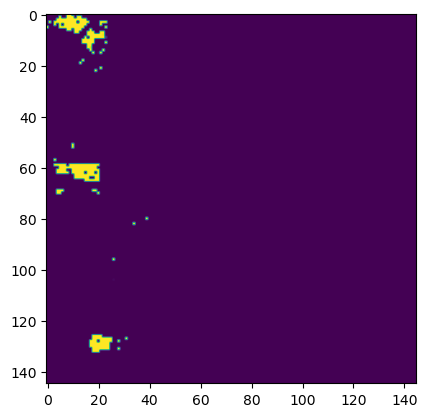

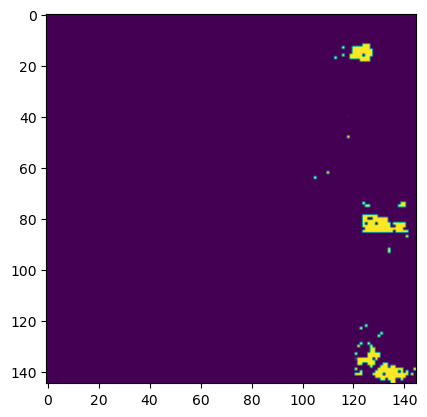

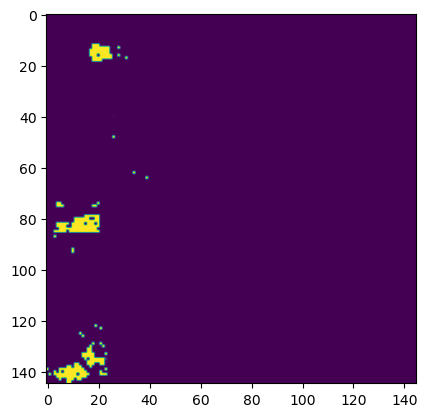

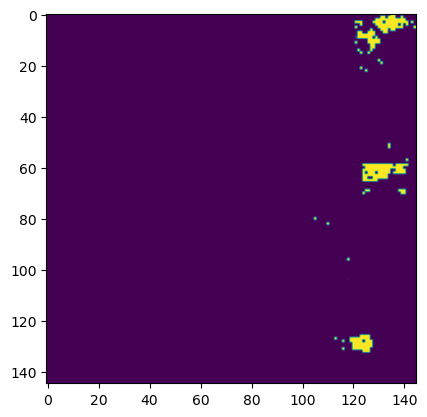

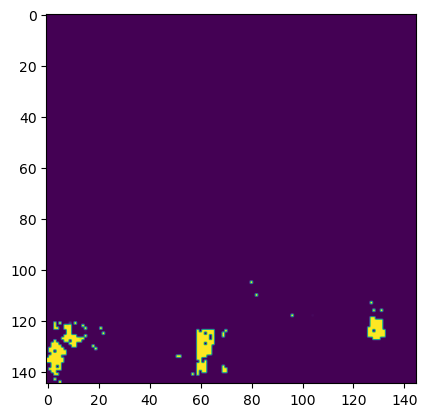

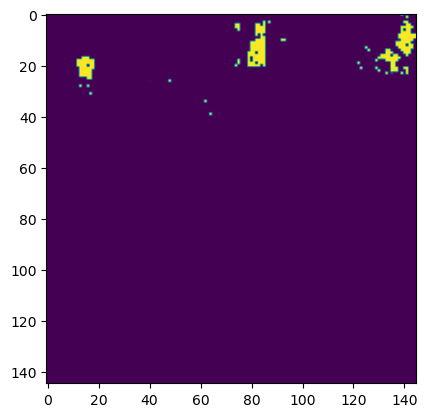

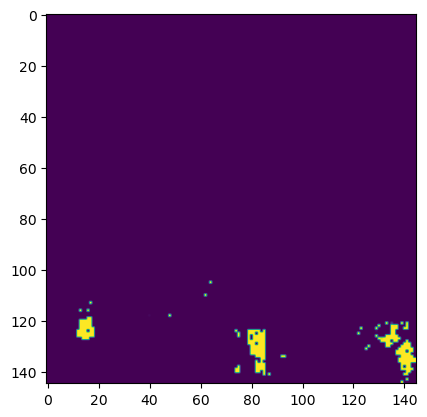

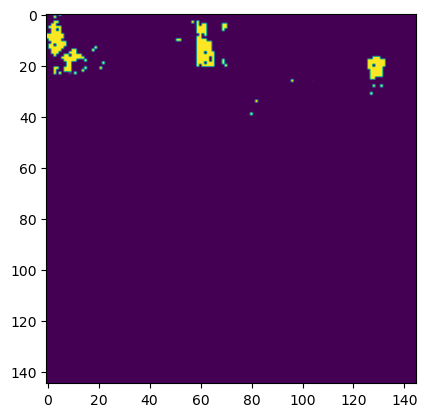

In [48]:
plt.imshow(INPUT_DATA_ip[2][0][0][0,:,:,3])
plt.show()
plt.imshow(INPUT_DATA_ip[2][0][0][1,:,:,3])
plt.show()
plt.imshow(INPUT_DATA_ip[2][0][0][2,:,:,3])
plt.show()
plt.imshow(INPUT_DATA_ip[2][0][0][3,:,:,3])
plt.show()
plt.imshow(INPUT_DATA_ip[2][1][0][0,:,:,3])
plt.show()
plt.imshow(INPUT_DATA_ip[2][1][0][1,:,:,3])
plt.show()
plt.imshow(INPUT_DATA_ip[2][1][0][2,:,:,3])
plt.show()
plt.imshow(INPUT_DATA_ip[2][1][0][3,:,:,3])
plt.show()

In [151]:
#dataset = TensorDataset(INPUT_DATA[0], INPUT_DATA[1], INPUT_DATA[2])
#dataloader = DataLoader(dataset, batch_size=1)
for TRAIN_IMG, TRAIN_Y, TRAIN_PL in zip(INPUT_DATA[0], INPUT_DATA[1], INPUT_DATA[2]):
    print(TRAIN_IMG.shape)
    print(TRAIN_Y.shape)
    print(TRAIN_PL[0].shape)
    print("========")
    first = True
    batch_size = 600
    if TRAIN_IMG.shape[1] > TRAIN_IMG.shape[2]:
        dataset = TensorDataset(TRAIN_IMG.permute(1,0,2,3), TRAIN_Y.permute(1,0,2), TRAIN_PL[0].permute(1,0,2,3))
        dataloader = DataLoader(dataset, batch_size=batch_size)
    else:
        dataset = TensorDataset(TRAIN_IMG.permute(2,1,0,3), TRAIN_Y.permute(2,1,0), TRAIN_PL[0].permute(2,1,0,3))
        dataloader = DataLoader(dataset, batch_size=batch_size)
        first = False
    # for i_num, (k_scores, k_TRAIN_Y) in enumerate(zip(scores[k_Layer], TRAIN_Y)):
    for id_batch, (TRAIN_IMG, TRAIN_Y, TRAIN_PL) in enumerate(dataloader):
        if first:
            TRAIN_PL = [TRAIN_PL.permute(1,0,2,3)]
            TRAIN_Y = TRAIN_Y.permute(1,0,2)
            TRAIN_IMG = TRAIN_IMG.permute(1, 3, 0, 2)
        else:
            TRAIN_PL = [TRAIN_PL.permute(2,1,0,3)]
            TRAIN_Y = TRAIN_Y.permute(2,1,0)
            TRAIN_IMG = TRAIN_IMG.permute(2,3,1,0)
        print(id_batch)
        print(TRAIN_IMG.shape)
        print(TRAIN_Y.shape)
        print(TRAIN_PL[0].shape)
        print("========")

torch.Size([4, 16640, 710, 147])
torch.Size([4, 16640, 710])
torch.Size([4, 16640, 710, 18])
0
torch.Size([4, 147, 600, 710])
torch.Size([4, 600, 710])
torch.Size([4, 600, 710, 18])
1
torch.Size([4, 147, 600, 710])
torch.Size([4, 600, 710])
torch.Size([4, 600, 710, 18])
2
torch.Size([4, 147, 600, 710])
torch.Size([4, 600, 710])
torch.Size([4, 600, 710, 18])
3
torch.Size([4, 147, 600, 710])
torch.Size([4, 600, 710])
torch.Size([4, 600, 710, 18])
4
torch.Size([4, 147, 600, 710])
torch.Size([4, 600, 710])
torch.Size([4, 600, 710, 18])
5
torch.Size([4, 147, 600, 710])
torch.Size([4, 600, 710])
torch.Size([4, 600, 710, 18])
6
torch.Size([4, 147, 600, 710])
torch.Size([4, 600, 710])
torch.Size([4, 600, 710, 18])
7
torch.Size([4, 147, 600, 710])
torch.Size([4, 600, 710])
torch.Size([4, 600, 710, 18])
8
torch.Size([4, 147, 600, 710])
torch.Size([4, 600, 710])
torch.Size([4, 600, 710, 18])
9
torch.Size([4, 147, 600, 710])
torch.Size([4, 600, 710])
torch.Size([4, 600, 710, 18])
10
torch.Size([4,

In [135]:
print(INPUT_DATA_ip[0][1].shape)
print(INPUT_DATA_ip[2][0][0].shape)

torch.Size([4, 200, 145, 145])
torch.Size([4, 145, 145, 17])


In [99]:
aa = INPUT_DATA[0]
bb = INPUT_DATA[1]
cc = INPUT_DATA[2]
dataset = TensorDataset(aa[0][0], bb[0][0], cc[0][0][0])
dataloader = DataLoader?
(dataset, batch_size = 100)

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (2217353672.py, line 6)

In [100]:
DataLoader?

In [60]:
for id_batch, (x_batch, y_batch, z_batch) in enumerate(dataloader):
    print(id_batch)
    print(x_batch.shape)
    

0
torch.Size([1, 147, 16640, 710])
1
torch.Size([1, 147, 16640, 710])
2
torch.Size([1, 147, 16640, 710])
3
torch.Size([1, 147, 16640, 710])


In [72]:
len(INPUT_DATA_ip[2])

2

In [129]:
dataset = TensorDataset(torch.Tensor(img), torch.Tensor(train_gt),torch.Tensor(gt), torch.Tensor(pseudo_labels3))

In [ ]:
dataloader = DataLoader(dataset, batch_size = 200)

In [111]:
for id_batch, (x_batch, y_batch, z_batch) in enumerate(dataloader):
    print(id_batch)
    print(x_batch.shape)
    print(y_batch.shape)
    print(z_batch.shape)

0
torch.Size([100, 710, 147])
torch.Size([100, 710])
torch.Size([100, 710, 18])
1
torch.Size([100, 710, 147])
torch.Size([100, 710])
torch.Size([100, 710, 18])
2
torch.Size([100, 710, 147])
torch.Size([100, 710])
torch.Size([100, 710, 18])
3
torch.Size([100, 710, 147])
torch.Size([100, 710])
torch.Size([100, 710, 18])
4
torch.Size([100, 710, 147])
torch.Size([100, 710])
torch.Size([100, 710, 18])
5
torch.Size([100, 710, 147])
torch.Size([100, 710])
torch.Size([100, 710, 18])
6
torch.Size([100, 710, 147])
torch.Size([100, 710])
torch.Size([100, 710, 18])
7
torch.Size([100, 710, 147])
torch.Size([100, 710])
torch.Size([100, 710, 18])
8
torch.Size([100, 710, 147])
torch.Size([100, 710])
torch.Size([100, 710, 18])
9
torch.Size([100, 710, 147])
torch.Size([100, 710])
torch.Size([100, 710, 18])
10
torch.Size([100, 710, 147])
torch.Size([100, 710])
torch.Size([100, 710, 18])
11
torch.Size([100, 710, 147])
torch.Size([100, 710])
torch.Size([100, 710, 18])
12
torch.Size([100, 710, 147])
torch.S

103
torch.Size([100, 710, 147])
torch.Size([100, 710])
torch.Size([100, 710, 18])
104
torch.Size([100, 710, 147])
torch.Size([100, 710])
torch.Size([100, 710, 18])
105
torch.Size([100, 710, 147])
torch.Size([100, 710])
torch.Size([100, 710, 18])
106
torch.Size([100, 710, 147])
torch.Size([100, 710])
torch.Size([100, 710, 18])
107
torch.Size([100, 710, 147])
torch.Size([100, 710])
torch.Size([100, 710, 18])
108
torch.Size([100, 710, 147])
torch.Size([100, 710])
torch.Size([100, 710, 18])
109
torch.Size([100, 710, 147])
torch.Size([100, 710])
torch.Size([100, 710, 18])
110
torch.Size([100, 710, 147])
torch.Size([100, 710])
torch.Size([100, 710, 18])
111
torch.Size([100, 710, 147])
torch.Size([100, 710])
torch.Size([100, 710, 18])
112
torch.Size([100, 710, 147])
torch.Size([100, 710])
torch.Size([100, 710, 18])
113
torch.Size([100, 710, 147])
torch.Size([100, 710])
torch.Size([100, 710, 18])
114
torch.Size([100, 710, 147])
torch.Size([100, 710])
torch.Size([100, 710, 18])
115
torch.Size([

In [125]:
data = [i for i in dataloader]

In [132]:
inp = [pre_data(i[0], i[1], {}, i[2], i[3]) for i in dataloader]

ValueError: step must be greater than zero

In [133]:
pre_data(img, train_gt, {}, gt, pseudo_labels3)

KeyboardInterrupt: 